This section of the code prepares the dataset for model training by:

1. Loading and Preprocessing the Dataset:
  - mitbih_train.csv and mitbih_test.csv: These datasets are loaded from CSV files into Pandas DataFrames. These datasets contain ECG heartbeat signals that will be used for training and testing.
      - The dataset is from the MIT-BIH Arrhythmia Database, a well-known source for ECG data used to classify different types of heartbeats (normal vs arrhythmia).
2. Separating Features and Labels:
  - X_train and X_test: These represent the input features (ECG signals) from the training and testing datasets, excluding the last column (which contains the labels).
  - y_train and y_test: These represent the target labels or classes for the heartbeat classification. The last column of the dataset is extracted to provide the labels, which will be used for training the models.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Bidirectional, LSTM, Reshape
from sklearn.metrics import classification_report
import xgboost as xgb
import shap
import lime
import lime.lime_tabular

# Load and preprocess the data
mitbih_train = pd.read_csv('F:/course/my_project/Heart/Data/mitbih_train.csv', header=None)
mitbih_test = pd.read_csv('F:/course/my_project/Heart/Data/mitbih_test.csv', header=None)



1. The input shape is (17, 11, 1), representing the dimensionality of the input ECG signal:
    - 17: Time steps (or segments of the ECG signal).
    - 11: Features per time step (likely derived from signal processing or down-sampling).
    - 1: Channel (since this is a single-channel ECG signal).

2. Convolutional Layers (Feature Extraction):
    - Conv2D(32): The first convolutional layer applies 32 filters of size 3x3 to the input, which helps capture local features from the ECG signal.
    - MaxPooling2D: Reduces the spatial dimensions by downsampling the feature map using a 2x2 pooling window, which reduces computation and helps with overfitting.
    - Dropout(0.25): Adds a dropout layer, which randomly drops 25% of the neurons during training to reduce overfitting and ensure the model generalizes well to unseen data.
    - The second convolutional block applies 64 filters with a smaller 2x2 kernel size and performs similar operations (pooling and dropout). The purpose of this block is to capture more detailed patterns from the ECG signal.
    
3. Reshaping for LSTM:
    - After the convolutional layers, the output is flattened and reshaped to be compatible with the LSTM layer. The reshaping turns the CNN output into a 2D sequence that can be processed by LSTM, where:
        - x.shape[1] becomes the new time dimension, and the features are concatenated into a single feature vector for each time step.

4. LSTM Layers (Sequence Learning):
    - LSTM(64): The first LSTM layer contains 64 units and is set to return the entire sequence (using return_sequences=True). This means that the LSTM layer outputs a sequence for every time step, allowing the next LSTM layer to learn dependencies from this sequence.
    - LSTM(32): The second LSTM layer has 32 units and outputs the final sequence representation of the input ECG data.

5. Dense and Dropout Layers (Fully Connected Layers):
    - Dense(128): A fully connected layer with 128 neurons that learns higher-level patterns from the LSTM output.
    - Dropout(0.5): A dropout layer that randomly drops 50% of the neurons to prevent overfitting during training.

6. Output Layer:
    - Dense(5): The final output layer contains 5 neurons, corresponding to the 5 classes of heartbeat signals in the MIT-BIH dataset (N, S, V, F, and Q).
    - Softmax Activation: The softmax function is used to output probabilities for each class, with the class having the highest probability being the model's prediction.

7. Model Compilation:
    - Adam Optimizer: A popular optimizer that combines the benefits of both momentum and adaptive learning rates, leading to faster and more stable convergence.
    - Sparse Categorical Crossentropy: Used as the loss function since the target variable (y_train) is a single integer representing the class index. This is suitable for multi-class classification problems.
    - Accuracy: The model will track accuracy as a performance metric during training.


In [3]:
# Separate features and labels
X_train = mitbih_train.iloc[:, :-1].values
y_train = mitbih_train.iloc[:, -1].values

X_test = mitbih_test.iloc[:, :-1].values
y_test = mitbih_test.iloc[:, -1].values


# Define the CNN-BiLSTM Model
def create_cnn_bilstm_model():
    inputs = Input(shape=(17, 11, 1))
    
    # Convolutional layers
    x = Conv2D(256, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, kernel_size=(2, 2), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Reshape the data to be suitable for LSTM
    x = Reshape((x.shape[1], -1))(x)
    
    # BiLSTM layers
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(32))(x)
    
    # Dense layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer
    outputs = Dense(5, activation='softmax')(x)  # 5 classes for MIT-BIH
    
    # Build the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model 
#https://doi.org/10.1186/s12911-021-01736-y

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Reshape, Bidirectional, LSTM, Dense
import netron

# === Your model definition ===
def create_cnn_bilstm_model():
    inputs = Input(shape=(17, 11, 1))
    
    # Convolutional Layers
    x = Conv2D(256, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, kernel_size=(2, 2), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Reshape the data to be suitable for LSTM
    x = Reshape((x.shape[1], -1))(x)
    
    # BiLSTM Layers
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(32))(x)
    
    # Dense Layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output Layer (5 classes for MIT-BIH)
    outputs = Dense(5, activation='softmax')(x)
    
    # Build the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# === Create and save the model ===
model = create_cnn_bilstm_model()

# Optionally, show a summary in the console (not required for Netron)
model.summary()

# Save as HDF5 so Netron can read it
model.save("cnn_bilstm_model.h5")

# === Start Netron to visualize the model ===
netron.start("cnn_bilstm_model.h5")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 17, 11, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 9, 256)     │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 3, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 3, 256)         │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,877 (1.83 MB)

 Trainable params: 479,877 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

Serving 'cnn_bilstm_model.h5' at http://localhost:8080


('localhost', 8080)

: 

In [4]:

# Setup Stratified K-Fold
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

fold_no = 1
batch_size = 128

final_predictions = []
final_true_labels = []
final_probs = []  # To store probabilities for each fold

for train_index, val_index in skf.split(X_train, y_train):
    print(f"Training fold {fold_no}...")

    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Apply SMOTE to the training fold only
    smote = SMOTE(random_state=42)
    X_train_fold_smote, y_train_fold_smote = smote.fit_resample(X_train_fold, y_train_fold)

    # Standardize data
    scaler = StandardScaler()
    X_train_fold_smote = scaler.fit_transform(X_train_fold_smote)
    X_val_fold = scaler.transform(X_val_fold)

    # Reshape the data for Conv2D
    X_train_fold_reshaped = X_train_fold_smote.reshape(-1, 17, 11, 1)
    X_val_fold_reshaped = X_val_fold.reshape(-1, 17, 11, 1)

    # Flatten the validation data for SHAP (store after the loop)
    X_val_flat = X_val_fold_reshaped.reshape(X_val_fold_reshaped.shape[0], -1)

    # Create the CNN-BiLSTM Model
    model = create_cnn_bilstm_model()

    # Add early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train_fold_reshaped, y_train_fold_smote,
                        epochs=10,
                        batch_size=batch_size,
                        validation_data=(X_val_fold_reshaped, y_val_fold),
                        callbacks=[early_stopping])

    # Step 4: Extract Features from CNN-BiLSTM Model for the Current Fold
    feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)
    
    X_train_features = feature_extractor.predict(X_train_fold_reshaped)
    X_val_features = feature_extractor.predict(X_val_fold_reshaped)
    
    # Step 5: Train XGBoost on Extracted Features for the Current Fold
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=5,
        eval_metric='mlogloss',
        use_label_encoder=False
    )
    
    xgb_model.fit(X_train_features, y_train_fold_smote)

    # Evaluate the XGBoost model on the validation set
    y_val_pred = xgb_model.predict(X_val_features)
    y_val_prob = xgb_model.predict_proba(X_val_features)  # Get probabilities for ROC

    final_predictions.extend(y_val_pred)
    final_true_labels.extend(y_val_fold)
    final_probs.extend(y_val_prob)  # Append probabilities for the current fold

    # Print classification report for the current fold
    print(f"Classification Report for Fold {fold_no}:\n", classification_report(y_val_fold, y_val_pred, target_names=['N', 'S', 'V', 'F', 'Q']))

    # Clear the session to free up memory
    tf.keras.backend.clear_session()

    fold_no += 1

#10.1088/1361-6579/aad7e4

Training fold 1...
Epoch 1/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 126s 60ms/step - accuracy: 0.7821 - loss: 0.5717 - val_accuracy: 0.9151 - val_loss: 0.2266
Epoch 2/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 113s 60ms/step - accuracy: 0.9473 - loss: 0.1498 - val_accuracy: 0.9130 - val_loss: 0.2277
Epoch 3/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 109s 58ms/step - accuracy: 0.9664 - loss: 0.0968 - val_accuracy: 0.9574 - val_loss: 0.1229
Epoch 4/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 104s 55ms/step - accuracy: 0.9736 - loss: 0.0762 - val_accuracy: 0.9473 - val_loss: 0.1488
Epoch 5/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 105s 55ms/step - accuracy: 0.9783 - loss: 0.0633 - val_accuracy: 0.9592 - val_loss: 0.1194
Epoch 6/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 103s 55ms/step - accuracy: 0.9809 - loss: 0.0557 - val_accuracy: 0.9625 - val_loss: 0.1157
Epoch 7/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 103s 55ms/step - accuracy: 0.9825 - loss: 0.0512 - val_accuracy: 0.9608 - val_loss: 0.1274
Epoch 8/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 106s 56m

f:\programs\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for Fold 1:
               precision    recall  f1-score   support

           N       0.99      0.99      0.99     24157
           S       0.79      0.82      0.81       741
           V       0.94      0.94      0.94      1930
           F       0.77      0.80      0.78       213
           Q       0.98      0.98      0.98      2144

    accuracy                           0.98     29185
   macro avg       0.89      0.91      0.90     29185
weighted avg       0.98      0.98      0.98     29185


Training fold 2...
Epoch 1/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 121s 58ms/step - accuracy: 0.7815 - loss: 0.5705 - val_accuracy: 0.9053 - val_loss: 0.2644
Epoch 2/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 113s 60ms/step - accuracy: 0.9470 - loss: 0.1527 - val_accuracy: 0.9303 - val_loss: 0.1925
Epoch 3/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 110s 58ms/step - accuracy: 0.9660 - loss: 0.0996 - val_accuracy: 0.9469 - val_loss: 0.1567
Epoch 4/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 104s 55ms/step 

f:\programs\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:32:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for Fold 2:
               precision    recall  f1-score   support

           N       0.99      0.99      0.99     24157
           S       0.79      0.85      0.82       741
           V       0.93      0.95      0.94      1929
           F       0.75      0.81      0.78       214
           Q       0.98      0.99      0.98      2144

    accuracy                           0.98     29185
   macro avg       0.89      0.92      0.90     29185
weighted avg       0.98      0.98      0.98     29185

Training fold 3...
Epoch 1/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 118s 57ms/step - accuracy: 0.7792 - loss: 0.5751 - val_accuracy: 0.9234 - val_loss: 0.2147
Epoch 2/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 112s 59ms/step - accuracy: 0.9487 - loss: 0.1445 - val_accuracy: 0.9439 - val_loss: 0.1536
Epoch 3/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 104s 55ms/step - accuracy: 0.9672 - loss: 0.0952 - val_accuracy: 0.9384 - val_loss: 0.1739
Epoch 4/10
1888/1888 ━━━━━━━━━━━━━━━━━━━━ 105s 55ms/step -

f:\programs\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:15:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for Fold 3:
               precision    recall  f1-score   support

           N       0.99      0.99      0.99     24157
           S       0.79      0.81      0.80       741
           V       0.95      0.95      0.95      1929
           F       0.81      0.72      0.77       214
           Q       0.98      0.98      0.98      2143

    accuracy                           0.98     29184
   macro avg       0.90      0.89      0.90     29184
weighted avg       0.98      0.98      0.98     29184



### Key Observations:

1. Class Imbalance: The normal heartbeat class ("N") has many more instances than the other classes. The model performs extremely well on this class, but struggles on minority classes like "S" (supraventricular premature beat) and "F" (fusion of ventricular and normal beats).

2. Minority Classes: The precision and F1-score for classes "S" and "F" are relatively lower, indicating difficulty in correctly predicting these classes. This could be due to the class imbalance, where there are far fewer examples of these beats for the model to learn from.

3. High Recall for Most Classes: The model generally performs well in terms of recall, which means it is good at identifying the true positive instances across most classes.

4. Imbalanced Performance: While the model performs excellently for the majority class ("N"), it struggles with some of the minority classes, especially class "S" (supraventricular premature beat). Improving performance on these minority classes would require techniques such as adjusting class weights, further balancing the dataset, or using advanced techniques like ensemble methods.

In [5]:

# Final classification report across all folds
print("Final Classification Report Across All Folds:\n", classification_report(final_true_labels, final_predictions, target_names=['N', 'S', 'V', 'F', 'Q']))

Final Classification Report Across All Folds:
               precision    recall  f1-score   support

           N       0.99      0.99      0.99     72471
           S       0.79      0.83      0.81      2223
           V       0.94      0.95      0.94      5788
           F       0.77      0.78      0.78       641
           Q       0.98      0.98      0.98      6431

    accuracy                           0.98     87554
   macro avg       0.89      0.90      0.90     87554
weighted avg       0.98      0.98      0.98     87554



In [6]:
import joblib

# Save the XGBoost model
joblib.dump(xgb_model, f"xgb_model_fold_{fold_no}.pkl")
print(f"XGBoost model for fold {fold_no} saved.")



XGBoost model for fold 4 saved.


In [7]:
import os

def save_model(model, fold_no, save_dir="saved_models"):
    """
    Save the trained CNN-BiLSTM model for a specific fold.

    Parameters:
    - model: Trained model to be saved.
    - fold_no: Fold number for naming the saved model file.
    - save_dir: Directory where the model will be saved (default: 'saved_models').

    Returns:
    - str: Path to the saved model file.
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Define the model file path
    model_file = os.path.join(save_dir, f"cnn_bilstm_model_fold_{fold_no}.h5")

    # Save the model
    model.save(model_file)
    print(f"Model for fold {fold_no} saved to {model_file}.")
    
    return model_file




In [38]:
# Load the existing features_fold_4.npz file
features_path = "features_fold_4.npz"
features = np.load(features_path)

# Save all existing keys along with y_val_pred and y_val_prob
np.savez_compressed(
    features_path, 
    X_train_features=features["X_train_features"], 
    X_val_features=features["X_val_features"], 
    y_train_fold_smote=features["y_train_fold_smote"], 
    y_val_fold=features["y_val_fold"], 
    y_val_pred=y_val_pred,  # Add predictions
    y_val_prob=y_val_prob, 
    X_val_fold_reshaped=X_val_fold_reshaped,
     # Add probabilities
)
print("Updated features_fold_4.npz with predictions and probabilities.")


Updated features_fold_4.npz with predictions and probabilities.


In [39]:
import numpy as np
features_path = "features_fold_4.npz"
features = np.load(features_path)

print("Keys in features_fold_4.npz:", features.keys())
print("Shape of X_val_fold_reshaped:", features["X_val_fold_reshaped"].shape)


Keys in features_fold_4.npz: KeysView(NpzFile 'features_fold_4.npz' with keys: X_train_features, X_val_features, y_train_fold_smote, y_val_fold, y_val_pred...)
Shape of X_val_fold_reshaped: (29184, 17, 11, 1)


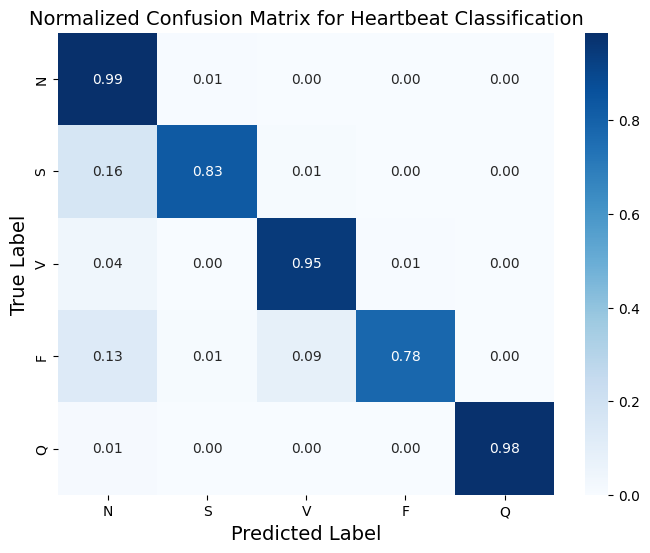

Confusion matrix plot saved as SVG


In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# Define the class labels
labels = ['N', 'S', 'V', 'F', 'Q']

# Compute the confusion matrix
conf_matrix = confusion_matrix(final_true_labels, final_predictions)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Normalized Confusion Matrix for Heartbeat Classification', fontsize=14)

# Save the plot as SVG
plt.savefig("confusion_matrix.svg", format="svg")

# Show the plot
plt.show()

print(f"Confusion matrix plot saved as SVG")

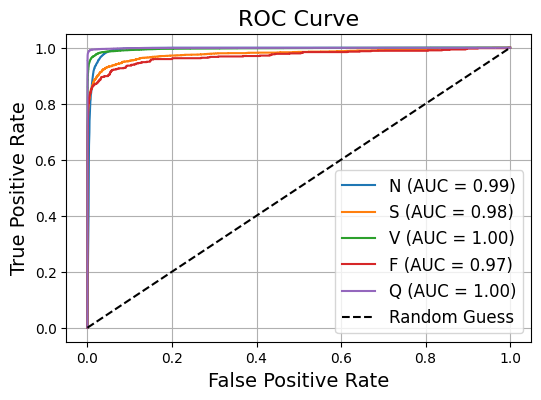

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Function to plot ROC curve
def plot_roc_curve(true_labels, predicted_probs, class_labels):
    """
    Plots the ROC curve for multi-class classification.

    Parameters:
    - true_labels: Array of true class labels.
    - predicted_probs: Array of predicted probabilities for each class.
    - class_labels: List of class label names.
    """
    plt.figure(figsize=(6, 4))

    for i, label in enumerate(class_labels):
        # Compute the false positive rate and true positive rate
        fpr, tpr, _ = roc_curve(np.array(true_labels) == i, np.array(predicted_probs)[:, i])
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve for the class
        plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

    # Plot the random guess line
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

    # Add labels and title
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("ROC Curve", fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid()

    # Show the plot
    plt.show()

# Example Usage
class_labels = ["N", "S", "V", "F", "Q"]  # Replace with your class labels
plot_roc_curve(final_true_labels, final_probs, class_labels)


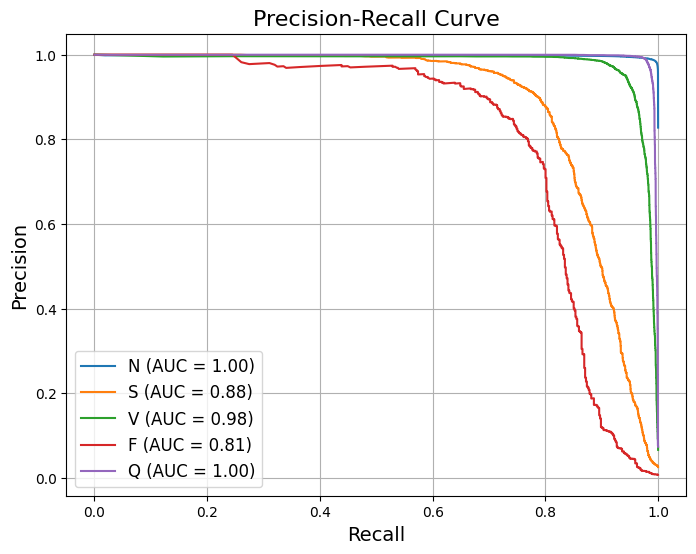

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(true_labels, predicted_probs, class_labels):
    """
    Plots the Precision-Recall curve for multi-class classification.

    Parameters:
    - true_labels: Array of true class labels.
    - predicted_probs: Array of predicted probabilities for each class.
    - class_labels: List of class label names.
    """
    plt.figure(figsize=(8, 6))

    for i, label in enumerate(class_labels):
        # Compute precision, recall
        precision, recall, _ = precision_recall_curve(np.array(true_labels) == i, np.array(predicted_probs)[:, i])
        pr_auc = auc(recall, precision)

        # Plot the Precision-Recall curve for the class
        plt.plot(recall, precision, label=f"{label} (AUC = {pr_auc:.2f})")

    # Add labels and title
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.title("Precision-Recall Curve", fontsize=16)
    plt.legend(loc="lower left", fontsize=12)
    plt.grid()

    # Show the plot
    plt.show()

# Example Usage
class_labels = ["N", "S", "V", "F", "Q"]  # Replace with your class labels
plot_precision_recall_curve(final_true_labels, final_probs, class_labels)


### Shap plot

1. Define a Masker for Image Data: A masker defines how SHAP will "perturb" or mask parts of the input when calculating feature importance. In this case, the Image masker blurs parts of the image (ECG signal reshaped into a 2D matrix) to estimate how much different regions of the image impact the model's prediction.

2. Define a Prediction Function: SHAP needs a function that generates model predictions for given input data. This function reshapes the data and passes it through your trained CNN-LSTM model (model), returning the predicted probabilities for each class.

3. Create the SHAP Explainer:SHAP uses the Explainer class to explain the model's predictions. The explainer is initialized with the predict function and the masker defined earlier. This allows SHAP to blur parts of the ECG image and measure how the model's prediction changes as different parts of the input are perturbed.

4. Select the Image(s) to Explain: Here, I select one image (ECG sample) from the validation data to explain. You can modify this line to explain multiple images if needed.

5. Compute SHAP Values: SHAP values are computed for the selected sample(s). This line configures the explainer to evaluate the importance of features (image pixels) up to n_evals times using a batch size of 80. The results focus on the top 5 classes using outputs=shap.Explanation.argsort.flip[:topk]. The SHAP values explain how each part of the ECG image affects the model’s prediction for each of the top-k classes.

6. Post-process SHAP Values: This block prepares the SHAP values for visualization. It ensures that the SHAP values are aligned properly with the input data (the ECG image).

7. Visualize the SHAP Values: The image_plot function generates a visualization of the SHAP values, where the impact of different parts of the ECG image on the model’s predictions is shown. The labels parameter is used to provide the class names ("N Class", "S Class", etc.).

Generating SHAP explanations...
(1, 17, 11, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


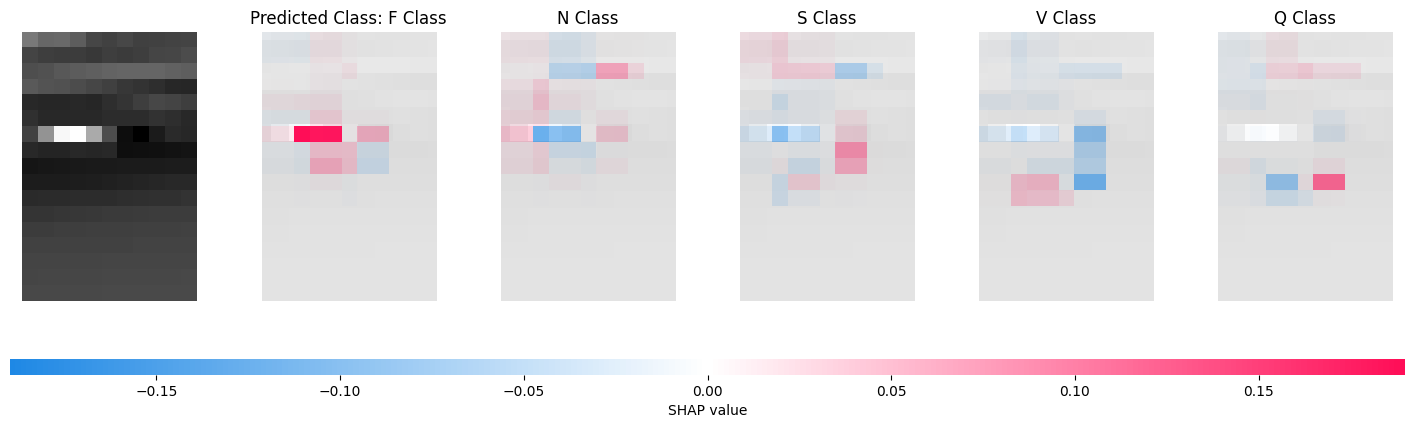

<Figure size 640x480 with 0 Axes>

In [32]:
import cv2

# SHAP Interpretation
print("Generating SHAP explanations...")
masker_blur = shap.maskers.Image("blur(128,128)", X_val_fold_reshaped[0].shape)

def predict(images):
    return model.predict(images)

explainer = shap.Explainer(predict, masker_blur)

# Feed one image (or more) to explain
n_evals = 1000
batch_size = 80
X_val_sample = X_val_fold_reshaped[27031:27032]  # explain one image, or change the slice to select more

# Display the shape of the selected sample to verify
print(X_val_sample.shape)

# Predict the class for the sample to determine the actual predicted label
predicted_probs = model.predict(X_val_sample)
predicted_class = np.argmax(predicted_probs)

# Titles for each image based on prediction
all_classes = ["N Class", "S Class", "V Class", "F Class", "Q Class"]

# Start with the predicted class
titles = [f"Predicted Class: {all_classes[predicted_class]}"]

# Add remaining classes, excluding the predicted one
for class_name in all_classes:
    if class_name != all_classes[predicted_class]:
        titles.append(class_name)

# Compute SHAP values
shap_values = explainer(
    X_val_sample,
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:len(titles) + 1],
)

# Post-process SHAP values for visualization
shap_values.data = X_val_sample[0]  # Use the original data for visualization
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

# Visualize the SHAP values
shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=titles
)
# Save the enhanced plot
plt.savefig("shap_plot.svg", dpi=600, bbox_inches="tight")
plt.close(fig)

In [40]:
# Extract masker_shape from X_val_fold_reshaped
masker_shape = features["X_val_fold_reshaped"][0].shape

# Save masker_shape to a new file
masker_shape_path = "masker_shape.npz"
np.savez_compressed(
    masker_shape_path,
    masker_shape=masker_shape  # Save only masker_shape
)

print(f"Saved masker_shape to {masker_shape_path}.")

Saved masker_shape to masker_shape.npz.


#### From the image, it appears that different parts of the signal contribute uniquely to each class's prediction:

1. F Class: The red highlights indicate positive contributions mainly around the central part, suggesting features in this area are increasing the likelihood of classifying it as normal.
2. N, S, V, Q Classes: Each class has distinct red and blue areas distributed across the features, indicating regions that either support or oppose the classification. Blue areas generally decrease the probability for a given class, whereas red areas enhance it.

1. Data Preparation: Flattening the Data: The 2D validation data X_val_fold_reshaped is reshaped into a 1D array using reshape. This makes the data compatible with the LIME explainer, which expects flat (tabular) data.

2. Prediction Function (predict_fn): The function reshapes the flattened data back to its original 2D shape (17x11x1) so that it can be passed to the CNN model for prediction.

3. LIME Tabular Explainer: 
    - Explainer Initialization: The LIME explainer (LimeTabularExplainer) is initialized with the training data (flattened), class names (N, S, V, F, Q), and feature names (feature_0, feature_1, ...).
    - Explanation: LIME then explains a specific instance from the validation data (instance_to_explain), showing the top 10 most important features that contribute to the predicted class.
4. Explanation Output:

    - Prediction Probabilities: The model predicted 55% probability for class "S" and 45% for class "N."
    - Feature Importance: LIME identified the features that most contributed to the prediction of class "S" (right) and the features that contributed to the prediction of "NOT S" (left).

In [90]:
# LIME Interpretation
print("Generating LIME explanations...")
X_val_flattened = X_val_fold_reshaped.reshape(X_val_fold_reshaped.shape[0], -1)

def predict_fn(data):
    data_reshaped = data.reshape(data.shape[0], 17, 11, 1)
    return model.predict(data_reshaped)

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_val_flattened,  # use flattened training data
    mode='classification',
    feature_names=[f'feature_{i}' for i in range(X_val_flattened.shape[1])],
    class_names=['N', 'S', 'V', 'F', 'Q'],
    discretize_continuous=False
)

# Select the first instance to explain
instance_to_explain = X_val_flattened[27031] #One third of train shape/ because of folding with 3

# Get the explanation for the instance
explanation = explainer.explain_instance(
    instance_to_explain, 
    predict_fn, 
    num_features=9,  # Show top 10 features
    top_labels=1  # Explain the prediction for the top predicted class
)
# Save the enhanced plot
#plt.savefig("lime_plot.svg", dpi=600, bbox_inches="tight")
# Visualize the explanation
explanation.save_to_file("lime_plot.html")
explanation.show_in_notebook(show_table=True, show_all=False)




Generating LIME explanations...
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Original SHAP values shape: (5, 17, 11, 5)
Original input data shape: (5, 17, 11, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Flattened SHAP values shape: (5, 187)
Flattened input data shape: (5, 187)
Generating SHAP summary plot for global feature importance...


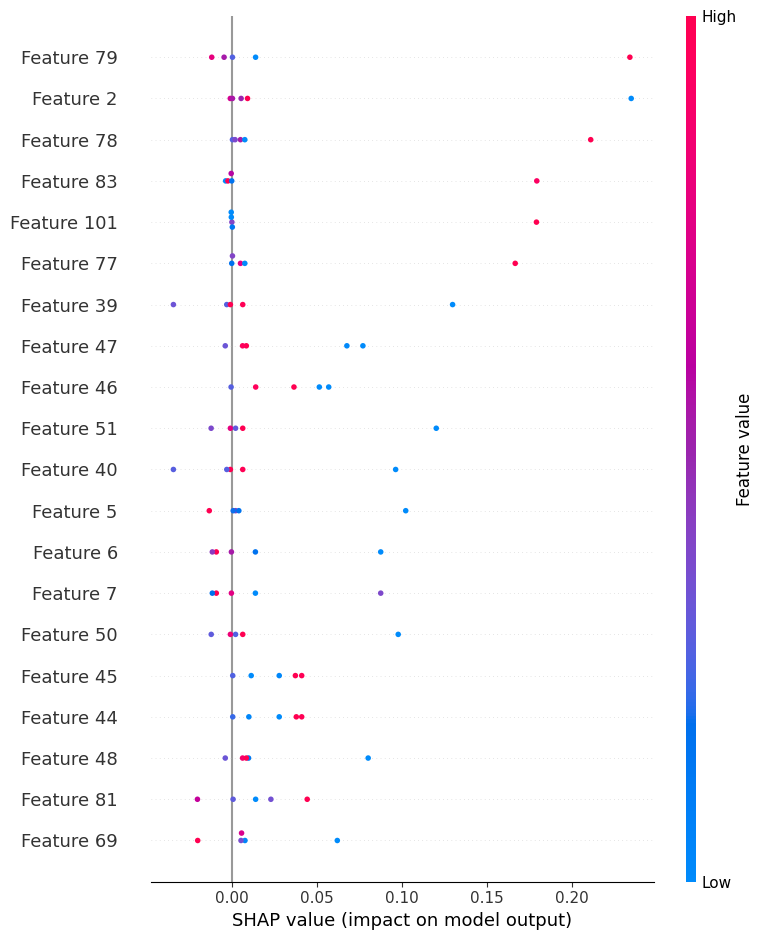

In [69]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Ensure SHAP JS visualization is initialized
shap.initjs()

# Debug: Print original shapes
print(f"Original SHAP values shape: {shap_values_array.shape}")  # (5, 17, 11, 5)
print(f"Original input data shape: {X_val_fold_reshaped[:5].shape}")  # (5, 17, 11, 1)

# Option 1: Select SHAP values for the predicted class
predicted_class = np.argmax(model.predict(X_val_fold_reshaped[:5]), axis=1)  # Get predicted class for each sample
shap_values_selected_class = np.array([
    shap_values_array[i, :, :, predicted_class[i]] for i in range(len(predicted_class))
])

# Option 2: Aggregate SHAP values across all classes
shap_values_aggregated = shap_values_array.mean(axis=-1)  # Mean over the class dimension

# Use the aggregated or selected SHAP values
shap_values_to_use = shap_values_selected_class  # Choose either shap_values_selected_class or shap_values_aggregated

# Flatten SHAP values from (5, 17, 11) to (5, 187)
shap_values_flattened = shap_values_to_use.reshape(shap_values_to_use.shape[0], -1)

# Flatten input data from (5, 17, 11, 1) to (5, 187)
X_val_flat = X_val_fold_reshaped[:5].reshape(X_val_fold_reshaped[:5].shape[0], -1)

# Debug: Check shapes after flattening
print(f"Flattened SHAP values shape: {shap_values_flattened.shape}")  # Should be (5, 187)
print(f"Flattened input data shape: {X_val_flat.shape}")  # Should be (5, 187)

# Ensure shapes match for plotting
assert shap_values_flattened.shape[1] == X_val_flat.shape[1], (
    f"Feature mismatch: SHAP features {shap_values_flattened.shape[1]}, "
    f"Input features {X_val_flat.shape[1]}"
)

# Generate feature names
feature_names = [f"Feature {i}" for i in range(X_val_flat.shape[1])]

# Create SHAP summary plot
print("Generating SHAP summary plot for global feature importance...")
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust size as needed
shap.summary_plot(
    shap_values_flattened,
    X_val_flat,
    feature_names=feature_names,
    plot_type="dot",  # Use 'dot' plot style for better visualization
    show=False  # Prevent automatic display
)
plt.savefig("global_shap_plot.svg", dpi=600, bbox_inches="tight")
plt.show()  # Display the plot




In [62]:
import numpy as np

# Assuming `shap_values_array` is already computed
shap_values_save_path = "shap_values.npz"

# Save SHAP values array
np.savez_compressed(
    shap_values_save_path,
    shap_values_array=shap_values_array
)
print(f"SHAP values saved to {shap_values_save_path}")


SHAP values saved to shap_values.npz
